# RFM-сегментация для da-vita.ru

## Загрузка данных

Необходимые библиотеки:

In [1]:
import pandas as pd
import re
import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt 

#### Чтение таблицы
Названия листов, столбцов и некоторые строки таблицы была предобработаны вручную.<br>
Функция для сведения всех листов в одну таблицу:

In [2]:
def read_excel_sheets(xlsx_path):
    print(f'Loading {xlsx_path} into pandas')
    xl = pd.ExcelFile(xlsx_path)
    df = pd.DataFrame()
    columns = None
    for idx, name in enumerate(xl.sheet_names):
        print(f'Reading sheet #{idx}: {name}')
        sheet = xl.parse(name)
        if idx == 0:
            columns = sheet.columns
        sheet.columns = columns
        df = df.append(sheet, ignore_index=True)
    return df

In [3]:
df = read_excel_sheets('orders.xlsx')

Loading orders.xlsx into pandas
Reading sheet #0: feb_2020
Reading sheet #1: jan_2020
Reading sheet #2: dec_2019
Reading sheet #3: nov_2019
Reading sheet #4: oct_2019
Reading sheet #5: aug_2019
Reading sheet #6: sep_2019
Reading sheet #7: jul_2019
Reading sheet #8: jun_2019
Reading sheet #9: may_2019
Reading sheet #10: apr_2019
Reading sheet #11: mar_2019
Reading sheet #12: feb_2019
Reading sheet #13: jan_2019
Reading sheet #14: oct_2018
Reading sheet #15: may_2018
Reading sheet #16: sep_2018
Reading sheet #17: dec_2018
Reading sheet #18: nov_2018
Reading sheet #19: jun_2018
Reading sheet #20: aug_2018
Reading sheet #21: jul_2018
Reading sheet #22: apr_2018
Reading sheet #23: mar_2018
Reading sheet #24: feb_2018
Reading sheet #25: jan_2018
Reading sheet #26: dec_2017
Reading sheet #27: nov_2017
Reading sheet #28: oct_2017
Reading sheet #29: aug_2017
Reading sheet #30: jul_2017
Reading sheet #31: jun_2017
Reading sheet #32: may_2017
Reading sheet #33: sep_2017
Reading sheet #34: apr_201

## Предобработка

Общая информация:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12660 entries, 0 to 12659
Data columns (total 11 columns):
oder_id           12638 non-null object
date              12337 non-null object
manager           12246 non-null object
order_content     11920 non-null object
customer          11891 non-null object
connect           11879 non-null object
deliver_method    11618 non-null object
deliver_point     12259 non-null object
order_sum         10780 non-null object
deliver_sum       1474 non-null object
final_sum         10762 non-null object
dtypes: object(11)
memory usage: 1.1+ MB


### Обработка пропусков

Подсчет пропусков:

In [5]:
df.isna().sum()

oder_id              22
date                323
manager             414
order_content       740
customer            769
connect             781
deliver_method     1042
deliver_point       401
order_sum          1880
deliver_sum       11186
final_sum          1898
dtype: int64

#### Количество пропусков в важных столбцах:
1880 пропусков в сумме заказа order_sum<br>
781 пропусков в контактах connect<br>
769 - имени клиента customer<br>
323 - в датах date<br>
Отбросим эти значения

Замена пропусков на 0:

In [6]:
df = df.fillna(0)

Подсчет нулевых значений в столбце финальной суммы order_sum после замены пропусков нулями:

In [7]:
df.query('order_sum == 0').count()

oder_id           1888
date              1888
manager           1888
order_content     1888
customer          1888
connect           1888
deliver_method    1888
deliver_point     1888
order_sum         1888
deliver_sum       1888
final_sum         1888
dtype: int64

Значений стало 1888, 8 значений изначально были равны 0.

Отбрасывание всех строк, где сумма заказа равна 0:

In [8]:
df.drop(df[df.order_sum == 0].index, inplace=True)

Подсчет нулевых значений в столбце с контактами клиента connect после замены пропусков нулями:

In [9]:
df.query('connect == 0').count()

oder_id           34
date              34
manager           34
order_content     34
customer          34
connect           34
deliver_method    34
deliver_point     34
order_sum         34
deliver_sum       34
final_sum         34
dtype: int64

Отбрасывание всех строк, где значение контакта клиента равно 0:

In [10]:
df.drop(df[df.connect == 0].index, inplace=True)

Подсчет нулевых значений в столбце с именем клиента customer после замены пропусков нулями:

In [11]:
df.query('customer == 0').count()

oder_id           19
date              19
manager           19
order_content     19
customer          19
connect           19
deliver_method    19
deliver_point     19
order_sum         19
deliver_sum       19
final_sum         19
dtype: int64

19 нулевых значений в имени покупателя, заменю 0 на LOST_NAME:

In [12]:
lost_name = df.query('customer == 0')
lost_name_list = lost_name['customer'].tolist()
df['customer'] = df['customer'].replace(lost_name_list, 'LOST_NAME')

Подсчет нулевых значений в столбце с датой date после замены пропусков нулями:

In [13]:
df.query('date == 0').count()

oder_id           11
date              11
manager           11
order_content     11
customer          11
connect           11
deliver_method    11
deliver_point     11
order_sum         11
deliver_sum       11
final_sum         11
dtype: int64

Отбрасывание всех строк, где значение даты равно 0:

In [14]:
df.drop(df[df.date == 0].index, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10727 entries, 4 to 12659
Data columns (total 11 columns):
oder_id           10727 non-null object
date              10727 non-null object
manager           10727 non-null object
order_content     10727 non-null object
customer          10727 non-null object
connect           10727 non-null object
deliver_method    10727 non-null object
deliver_point     10727 non-null object
order_sum         10727 non-null object
deliver_sum       10727 non-null object
final_sum         10727 non-null object
dtypes: object(11)
memory usage: 1005.7+ KB


#### Вывод:
<br>
<div style="border:solid blue 3px; padding: 20px">
После обработки пропусков удалено  1933 строки - 15% изначального датасета.
</div>

### Обработка выбивающихся значений, неявных дублей

#### Поиск тестовых заказов

In [16]:
df.customer.str.contains(pat='тес|марон|marr',regex=True).sum()

0

Строки, содержащие "тес", "марон", "marr" в столбце 'customer', не обнаружены (были отброшены вместе с пропущенными в столбце 'connect').

### Форматирование телефонных номер к единому виду

За нормальную длину примем номера 11 и 10 цифр.

#### Подсчет длины номеров

In [17]:
df['connect_len'] = df.connect.astype(str).str.len()

Просмотр значений:

In [18]:
df.connect_len.value_counts()

11    8943
13    1640
10      42
12      33
34       9
27       8
25       7
42       6
43       6
24       5
14       3
39       2
38       2
40       2
7        2
31       2
41       2
22       2
30       2
33       1
54       1
37       1
36       1
45       1
4        1
20       1
28       1
58       1
Name: connect_len, dtype: int64

Номера длинной 10 символов - 42 значения<br>
длиной 11 символов - 8943 значения<br>
12 символов - 33 значения<br>
13 символов - 1640 значений<br>
В таблице присутствую значения длиной 7 и 4 символа. Также, много значений более 13 символов.

Посмотрим на номера длиной 7 и 4:

In [19]:
df.query('connect_len < 10')

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
4450,8207,2019-03-04 00:00:00,Алина,П8092- 6 шт,Владимир,9236229,IML 04.03.19,СКЛАД Спб Ольминского дом 12,13905,0,13905,7
8928,4713,2018-07-25 00:00:00,Аня,"kz0164, 5267, and333, and600, 5206, 25200",LOST_NAME,Алла,самовывоз,самовывоз Пассаж,2947,0,2947,4
11248,DV1185-1,2017-10-20 00:00:00,Аня,MP678,Инесса,9959827,самовывоз,самовывоз Варшавская,1400,0,1400,7


Посмотрим на номера длиной 12 символов:

In [20]:
df.query('connect_len == 12')

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
540,12442,2020-01-20 00:00:00,Алина,"kd08,kd21,6151,6012",Лукашевич Татьяна Борисовна,375296632762,СДЭК,СКЛАД Витебск ул Велижская дом 6 оплачен сбер...,9204,0,9204,12
614,12517,2020-01-24 00:00:00,Алина,88115065,Аверкина Ирина Юрьевна,896070909709,самовывоз,самовывоз Таганка,2168,0,2168,12
832,11750,2019-12-05 00:00:00,Алина,"425046,425060,133365,424759,5012246,6012-2 шт",Лукашевич Татьяна Борисовна,375296632762,СДЭК,СКЛАД Витебск ул Велижская дом 6 оплачен сберб...,9008,0,9008,12
1060,11983,2019-12-18 00:00:00,Алина,MP598,Мальцева Ирина Викторовна,892665510843,самовывоз,самовывоз Таганская,1418,0,1418,12
1171,12098,2019-12-23 00:00:00,Алина,"6088, 6294, 6295","Верещагина Светлана Владимировна, 07883",791121691397,Pick Point 24.12.19,СКЛАД Спб Постамат: PickPoint: ТРК Лето 7801-...,1918,256,2174,12
1884,10830,2019-10-07 00:00:00,Алина,"6005, 6006, 6139, KZ 0445, 62013, 62037","Гладкова Юлия Анатольевна, 79219414341",9.21941e+09,IML 7.10.19,"СКЛАД ЛО, Пушкин ул Ленинградская дом 1 клиник...",10238,0,10238,12
1951,10895,2019-10-11 00:00:00,Алина,6006,Абрамов Александр Владимирович,9.16255e+09,самовывоз,самовывоз Кропотка,2618,0,2618,12
2415,10274 новый,2019-08-21 00:00:00,Алина,"td0073,mds02,50005,kz0291,62070,62074,8968010,...",Тимаева Анна Геннадьевна 24.03.18,899963950993,Pick Point 22.08.19,СКЛАД Омск 10 лет Октября ул дом 182 корпус 3...,4510,0,4510,12
2746,10604,2019-09-24 00:00:00,Алина,kd09,Лиховайда Инна Петровна,890543350742,самовывоз,самовывоз Просвет,2543,0,2543,12
3049,9884,2019-07-15 00:00:00,Алина,"1080,mp623,kz0247",Конькова Светлана 08.02.76,891178613891,IML 15.07.19,СКЛАД Спб площадь Растрелли дом 2 Банк Россия,3500,0,3500,12


Посмотрим на номера длиной 13 символов:

In [21]:
df.query('connect_len == 13')

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
1780,10587 новый,2019-09-23 00:00:00,Алина,"500067- 2шт, 25207, 25209, 25802, 25200- 2шт",Шумейко Александр Александрович 01.08.18,8.90986e+10,Pick Point 24.09.19,СКЛАД Комсомольск-на-Амуре ПВЗ: Westfalika: Ми...,4643,0,4643,13
1781,10591,2019-09-23 00:00:00,Аня,"6200, 6286, 500050, 500067","Ольга Иванова, 79106445245",8.91064e+10,Pick Point 26.09.19,"СКЛАД Рязань ПВЗ Фрунзе, 5",2221,270,2491,13
1783,10640,2019-09-25 00:00:00,Алина,62037- 3 шт,"Зарипова Наталья Викторовна, 79028259692",8.90283e+10,почта,"СКЛАД 628250, Тюменская область, Советский рай...",8700,0,8700,13
1784,10642 новый,2019-09-26 00:00:00,Алина,"25242,dsm265,4255,6296,5243,4850,5129,7428,743...",Алиева Егана Насреддин Кызы 04.10.19,8.92279e+10,Pick Point 26.09.19,"СКЛАД Ханты-Мансийск Постамат: ОКБ Пойдем, Чех...",7950,0,7950,13
1785,10648,2019-09-26 00:00:00,Алина,"205,936pro,907pro",Лазарева Лия,8.90964e+10,IML 02.10.19,СКЛАД Москва ул Кутузовский проспект дом 2/1 г...,3128,0,3128,13
...,...,...,...,...,...,...,...,...,...,...,...,...
12356,598,2017-04-27 00:00:00,Алина,"1001-03191, KD08","Наталья , 11088",8.92135e+10,самовывоз,самовывоз Пассаж,2520,0,2520,13
12357,599,2017-04-27 00:00:00,Алина,62096-4 шт,Кириллова Инна Сергеевна 16 05 79,8.91146e+10,почта,Калининград ул Майская дом 4 кв 78 оплачен сбе...,2016,275,2291,13
12358,600,2017-04-27 00:00:00,Алина,"MP708, MP678, MP774",Спиричева Владислава 25 04,8.98171e+10,Анатолий,СКЛАД Спб ул Латышских стрелков дом 5 корп 2 к...,4464,0,4464,13
12359,601,2017-04-27 00:00:00,Алина,"MJ41, MJ07, MJ06, MJ11, 822494,821176",Татьяна,8.9219e+10,самовывоз,самовывоз Пассаж,4314,0,4314,13


Посмотрим на номера длиной более 13 символов:

In [22]:
df.query('connect_len > 13')

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
149,12740,2020-02-11 00:00:00,Алина,"5173,7287164,mj47,mj16,mj61,127370,5176",Вишнивецкая Ольга Петровна 13.08.18,89111131164 или 89308514348,IML 12.02.20,СКЛАД СПб ул Шевченко дом 1,3020,0,3020,27
274,12863,2020-02-17 00:00:00,Алина,"4720015,4720022,6029,80615065,а10б4720084,4720...",Левченко Надежда Александровна 19796,89627189277 или 89110020099,IML 17.02.20,"СКЛАД Спб проспект Металлистов, дом 61 корпус ...",8125,0,8125,27
444,12340 новый,2020-01-13 00:00:00,Алина,"62066,6240,6003",Любовь 16.09.18,89166490139 получатель 89037921051 Алексей,IML 13.01.20,СКЛАД Москва ул Очаковское шоссе дом 34 Офисно...,6363,0,6363,43
446,12342,2020-01-13 00:00:00,Алина,"80615065,d20-2 шт,87815065,80923065,81315165,8...",Андрей,89857673999 получатель Андрей 89169567401,IML 13.01.20,СКЛАД Москва ул Научный проезд дом 17 оплачен...,17030,0,17030,41
448,12344,2020-01-13 00:00:00,Алина,"Ar4603,822",Орлов Виталий Владиславович (Ланцова Светлана ...,89161527776 получатель 89104041818,IML 13.01.20,СКЛАД МО Щелковское шоссе д Райки СНТ Роща д32,10910,0,10910,34
...,...,...,...,...,...,...,...,...,...,...,...,...
12427,181-1,2017-02-20 00:00:00,Алина,ДОСЫЛ ПРОДУКТА: MZ23 из Реализация товаров № У...,Лобанова Галина Николаевна,79085686054 galya.nik.kisa@mail.ru,Pick Point 07.03.17,"Иваново, Постамат: ТРК Ясень 3701-004\nСтроите...",-,0,-,34
12569,124,2017-02-07 00:00:00,Аня,"62093- 2 шт, 62096, 62095 - 3шт",Куница Алексей Викторович,"89184414478, a9184414478@gmail.com",Pick Point 14.02.17,"СКЛАД г.Краснодар, Boss-House",3029,0,3029,34
12623,181,2017-02-20 00:00:00,Алина,0,Лобанова Галина Николаевна,79085686054 galya.nik.kisa@mail.ru,Pick Point 28.02.17,"Иваново, Постамат: ТРК Ясень 3701-004\nСтроите...",14258,0,14258,34
12637,194,2017-02-21 00:00:00,Алина,"R-6043, sph1592, sph1663, 6060- 2 шт, mj42- 2 ...",Кузнецова Ольга Владимировна,"89122984215, карта 10370",почта,"Свердловская область, Ирбитский район, П.Пион...",4158,0,4158,24


#### Вывод:
Длина 4 и 7 - непонятные короткие номера, нужно отбросить.<br>
Длина 12 - номера выглядят как обычно, но имеют лишню цифру.<br>
Дина 13 - номера из 12 цифр с десятичным знаком. Скорее всего получились из-за того, что в экселе эти ячейки имели цифровой формат, при переводе в python образовались вещественные числа.<br>
Длина более 13 знаков - номер с дополнительными пометками. Пометки будут отсечены.

#### Форматирование длины номеров к единому виду:

Отсечение десятичного знака в номерах с 13 символами:

In [23]:
df.loc[df['connect_len'] == 13, 'connect'] = df['connect'].astype(str).str.split('.').apply(lambda x: x[0])

Отсечение пометок в номерах с более 13 символами:

In [24]:
df.loc[df['connect_len'] > 13, 'connect'] = df.connect.astype(str).str.split(r"[A-z]|[А-я]").apply(lambda x: x[0])
df.loc[df['connect_len'] > 13, 'connect'] = df.connect.astype(str).str.split(',').apply(lambda x: x[0])

Отбрасывание строк с номерами длиной 4 и 7 знаков:

In [25]:
df.drop(df[df.connect_len < 10].index, inplace=True)

Пересчет длины номеров:

In [26]:
df['connect_len'] = df.connect.astype(str).str.len()

In [27]:
df['connect_len'].value_counts()

11    10589
12       75
10       42
0         7
13        5
14        2
25        2
24        1
8         1
Name: connect_len, dtype: int64

После проделанных операций, остались номера с длиной от 13 символов. Также, 7 номеров были потеряны в процессе отсечения символов по условиям.

Посмотрим на оставшиеся номера от 13 символов:

In [28]:
df.query('connect_len >= 13')

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
525,12431,2020-01-20 00:00:00,Алина,"403279,dsm63,ah140,840729,840286",Сергеева Юлия Владимировна,891123892981 89697103130,самовывоз,самовывоз Пассаж,2222,0,2222,24
877,11796,2019-12-10 00:00:00,Алина,"6244, 402128- 7шт, MJ20- 3шт",Рублев Андрей Дмитриевич,89123611752 (89854683959),Pick Point 10.12.19,СКЛАД Киров ул Горького дом 55 А ТЦ Арбат Фикс...,2986,256,3242,25
1531,11371,2019-11-13 00:00:00,Алина,6011,Рублев Андрей Дмитриевич,89123611752 (89854683959),Pick Point 14.11.19,СКЛАД Киров ул Горького дом 55 А ТЦ Арбат Фикс...,4030,0,4030,25
1805,10722,2019-09-30 00:00:00,Алина,"6052- 2шт, A83, k82, L2, 80001955",Лукашевич Татьяна Борисовна,375296632762.0,СДЭК 11.10,СКЛАД Витебск ул Велижская дом 6 оплачен Сберб...,14681,0,14681,14
2112,11075,2019-10-24 00:00:00,Алина,"6003,25210,6151,6035","Григорьева Светлана Николаевна, 792417777720",892417777720.0,Pick Point 24.10.19,СКЛАД Якутск ПВЗ: Ростелеком: Каландарашвили у...,8051,0,8051,14
4271,8979,2019-04-26 00:00:00,Аня,"88115065, 82815066, 87915065","Дарина, 08947",79219526714 (,IML 26.04.19,"СКЛАД СПб Ул. Восстания 37-39, пом 14-н, Офис ...",8056,0,8056,13
9544,3323,2018-03-12 00:00:00,Аня,KD20,Виктория,8(903)6772229,самовывоз,самовывоз Таганка,2240,0,2240,13
9561,3341,2018-03-12 00:00:00,Аня,6006,Гусева Екатерина,8(921)3834197,самовывоз,самовывоз Варшавская,2712,0,2712,13
9568,3348,2018-03-12 00:00:00,Аня,"LDR10, SPh1495, SPh1472, SPh1596",Воронова Марина Игоревна,8(916)4355058,самовывоз,самовывоз Кропотка,2264,0,2264,13
11785,957,2017-06-19 00:00:00,Аня,"Sph1488, Sph1473, Sph1671, Sph1475, Sph1661","Есенина Екатерина Юрьевна, карта 33316",89165527545 (,IML 19.06.17,"СКЛАД Москва ул.Герасима Курина, 8 корп 1, кв ...",3915,0,3915,13


Двойные номер, скобки, и десятичные знаки.

Отсечение скобок и десятичных знаков:

In [29]:
df.loc[df['connect_len'] >= 13, 'connect'] = df.connect.astype(str).str.split('(').apply(lambda x: x[0])

In [30]:
df.loc[df['connect_len'] >= 13, 'connect'] = df.connect.astype(str).str.split('.').apply(lambda x: x[0])

Пересчет длины:

In [31]:
df['connect_len'] = df.connect.astype(str).str.len()

In [32]:
df['connect_len'].value_counts()

11    10589
12       81
10       42
0         7
1         3
24        1
8         1
Name: connect_len, dtype: int64

Отбрасывание оставшихся значений меньше 10 и больше 20:

In [33]:
df.drop(df[df.connect_len < 10].index, inplace=True)
df.drop(df[df.connect_len > 12].index, inplace=True)

In [34]:
df['connect_len'].value_counts()

11    10589
12       81
10       42
Name: connect_len, dtype: int64

Остались номера длиной 10 - без кода страны, 11 - с кодом, 12 знаков.

Просмотр номеров длиной 10 символов:

In [35]:
df_connect_len10 = df.query('connect_len == 10')
df_connect_len10

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
297,12886,2020-02-19 00:00:00,Алина,"dsm254,62050,62072,4616",Мария,8926423977,самовывоз,самовывоз Таганка,3320,0,3320,10
802,11720,2019-12-02 00:00:00,Аня,81815065,"Князева Светлана, 24390",9045515728,самовывоз,самовывоз Пассаж,1718,0,1718,10
948,11870,2019-12-15 00:00:00,Алина,"6296, 6102",Пелиновская Софья Михайловна,8650651205,самовывоз,самовывоз Пассаж,858,0,858,10
1141,12068,2019-12-22 00:00:00,Аня,комплект Black,"Игорь, 20723",9096896011,самовывоз,самовывоз Кропотка,8470,0,8470,10
3347,9545 новый,2019-06-10 00:00:00,Алина,"88415065,25231,25205,6181,8150,к85",Чернова Ирина 02.06.18,8903745903,IML 11.06.19,СКЛАД Москва ул Петрозаводская дом 22 кв 171,3964,0,3964,10
3732,9227,2019-05-16 00:00:00,Алина,"елз327,елз238",Томилина Лариса Михайловна,8903438528,самовывоз,самовывоз Таганская,2086,0,2086,10
3892,9396,2019-05-30 00:00:00,Алина,62012,"Железнова Светлана Александровна, 10088",9104783856,Pick Point 30.05.19,"СКЛАД Истра Постамат: ТЦ Истра-Сити, 9-й Гвард...",968,267,1235,10
4055,8760 новый,2019-04-08 00:00:00,Алина,"386758,402159,ml44,024361,25207",Гороховская Ирина 17.05.78,8903235237,IML 8.04.19,СКЛАД Москва ул Валовая дом 26 Административно...,3015,0,3015,10
4490,8247,2019-03-05 00:00:00,Алина,6004,Марина,9654030880,самовывоз,самовывоз Кропотка,2543,0,2543,10
4516,8271,2019-03-06 00:00:00,Алина,"kd38,sph1493",Смирнова В.С.,8921798330,самовывоз,самовывоз Пассаж,750,0,750,10


В списке замечены номера длиной 10, начинающиеся на 8. Последняя цифра номера отсутствует.<br>
Подсчет таких номеров:

In [36]:
df_connect_len10.connect.astype(str).str.contains(pat='8(\d{9})',regex=True).sum()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


13

12 номеров с отсутствующей последней цифрой.<br>


Замена таких номеров на 0:

In [37]:
df.loc[df['connect_len'] == 10, 'connect'] = df.connect.astype(str).str.replace('8(\d{9})', '0', regex=True)

In [38]:
df.query('connect_len == 10')

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
297,12886,2020-02-19 00:00:00,Алина,"dsm254,62050,62072,4616",Мария,0,самовывоз,самовывоз Таганка,3320,0,3320,10
802,11720,2019-12-02 00:00:00,Аня,81815065,"Князева Светлана, 24390",9045515728,самовывоз,самовывоз Пассаж,1718,0,1718,10
948,11870,2019-12-15 00:00:00,Алина,"6296, 6102",Пелиновская Софья Михайловна,0,самовывоз,самовывоз Пассаж,858,0,858,10
1141,12068,2019-12-22 00:00:00,Аня,комплект Black,"Игорь, 20723",9096896011,самовывоз,самовывоз Кропотка,8470,0,8470,10
3347,9545 новый,2019-06-10 00:00:00,Алина,"88415065,25231,25205,6181,8150,к85",Чернова Ирина 02.06.18,0,IML 11.06.19,СКЛАД Москва ул Петрозаводская дом 22 кв 171,3964,0,3964,10
3732,9227,2019-05-16 00:00:00,Алина,"елз327,елз238",Томилина Лариса Михайловна,0,самовывоз,самовывоз Таганская,2086,0,2086,10
3892,9396,2019-05-30 00:00:00,Алина,62012,"Железнова Светлана Александровна, 10088",9104783856,Pick Point 30.05.19,"СКЛАД Истра Постамат: ТЦ Истра-Сити, 9-й Гвард...",968,267,1235,10
4055,8760 новый,2019-04-08 00:00:00,Алина,"386758,402159,ml44,024361,25207",Гороховская Ирина 17.05.78,0,IML 8.04.19,СКЛАД Москва ул Валовая дом 26 Административно...,3015,0,3015,10
4490,8247,2019-03-05 00:00:00,Алина,6004,Марина,9654030880,самовывоз,самовывоз Кропотка,2543,0,2543,10
4516,8271,2019-03-06 00:00:00,Алина,"kd38,sph1493",Смирнова В.С.,0,самовывоз,самовывоз Пассаж,750,0,750,10


Отбрасывание строк с номерами телефоноф, замененных на 0:

In [39]:
df.drop(df[df.connect == '0'].index, inplace=True)

Прибавление кода страны 8 в начало номеров, состоящих из 10 знаков:

In [40]:
df.loc[df['connect_len'] == 10, 'connect'] = '8' + df['connect'].astype(str)

Пересчет длины номеров:

In [41]:
df['connect_len'] = df.connect.astype(str).str.len()

In [42]:
df['connect_len'].value_counts()

11    10618
12       81
Name: connect_len, dtype: int64

#### Вывод:
Остались номера длиной 11 и 12 символов.

#### Форматирование кода страны к единому формату - замена 7 на 8:

Замена 7 на 8 в номерах с 11 символами:

In [43]:
df.loc[df['connect_len'] >= 11, 'connect'] = df.connect.astype(str).str.replace('^7', '8',regex=True)

Проверка поиск номеров, начинающихся на 7 во всем датасете:

In [44]:
df.connect.astype(str).str.contains(pat='^7',regex=True).sum()

0

#### Вывод:
Код страны 7 во всех номерах изменен на 8.

#### Дополнительная проверка - поиск значений с буквами в столбце с номерами телефонов:

In [45]:
df.connect.str.contains(pat='[А-я]',regex=True).sum()

1

In [46]:
find_words = df.connect.str.contains(pat='[А-я]',regex=True)

In [47]:
df[find_words]

,oder_id,date,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len
3224,9370,2019-05-29 00:00:00,Алина,"282,62067,6241",Лыбин Андрей Сергеевич 09.07.76,новосибирск,Pick Point 4.06.19,СКЛАД Новокузнецк ПВЗ: Россита: Металлургов пр...,4057,0,4057,11


Слово - новосибирск<br>

Замена слова на 0:

In [48]:
df.loc[df['connect_len'] >= 11, 'connect'] = df.connect.astype(str).str.replace('[А-я]', '0',regex=True)

Отбрасывание строки:

In [49]:
df.drop(df[df.connect == '0'].index, inplace=True)

### Приведение данных к коррекным форматам

Форматы данных:

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10699 entries, 4 to 12659
Data columns (total 12 columns):
oder_id           10699 non-null object
date              10699 non-null object
manager           10699 non-null object
order_content     10699 non-null object
customer          10699 non-null object
connect           10699 non-null object
deliver_method    10699 non-null object
deliver_point     10699 non-null object
order_sum         10699 non-null object
deliver_sum       10699 non-null object
final_sum         10699 non-null object
connect_len       10699 non-null int64
dtypes: int64(1), object(11)
memory usage: 1.1+ MB


Ключевые столбцы содержат данные в неподходящем формате:<br>
'date' - строка, нужен формат даты,<br>
'order_sum', 'deliver_sum', 'final_sum' - строки, нужен формат вещественных чисел.

#### Формат даты:

При попытке форматирования даты к нужному формату возникла ошибка из-за наличия дат в произвольном формате, например, "5.3.19 новый". В некоторых случаях было замечено, что вместо даты указано имя менеджера - отредактировано вручную. Вместо 2018 года указан 2028 - отредактировано вручную.<br>
Выставлен параметр errors='coerce', который удаляет значения, неподходящие под формат даты, которые не были обнаружена и не были отредактированы вручную:

In [51]:
df['date'] = pd.to_datetime(df['date'], format='%Y.%m.%d', errors='coerce')

#### Формат колонок с суммами заказов:

В столбцах были обнаружены символы "-". Параметр errors='coerce' удалил такие значения:

In [52]:
cols = ['order_sum', 'deliver_sum', 'final_sum']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

#### Поиск пропусков:

In [53]:
df.isna().sum()

oder_id            0
date              18
manager            0
order_content      0
customer           0
connect            0
deliver_method     0
deliver_point      0
order_sum         19
deliver_sum        1
final_sum          3
connect_len        0
dtype: int64

#### Удаление пропусков:

In [54]:
df.dropna(subset=['date', 'order_sum'], inplace=True)
df = df.fillna(0)

In [55]:
df.isna().sum()

oder_id           0
date              0
manager           0
order_content     0
customer          0
connect           0
deliver_method    0
deliver_point     0
order_sum         0
deliver_sum       0
final_sum         0
connect_len       0
dtype: int64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10662 entries, 4 to 12659
Data columns (total 12 columns):
oder_id           10662 non-null object
date              10662 non-null datetime64[ns]
manager           10662 non-null object
order_content     10662 non-null object
customer          10662 non-null object
connect           10662 non-null object
deliver_method    10662 non-null object
deliver_point     10662 non-null object
order_sum         10662 non-null float64
deliver_sum       10662 non-null float64
final_sum         10662 non-null float64
connect_len       10662 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 1.1+ MB


#### Вывод:
Форматы заменены, пропуски удалены.

### Вывод по предообработке данных:
<br>
<div style="border:solid green 4px; padding: 20px">
<b>Первичная обработка пропусков:</b><br>
- 1880 пропусков в сумме заказа order_sum<br>
- 781 пропусков в контактах connect<br>
- 769 - имени клиента customer<br>
- 323 - в датах date<br>
После обработки пропусков удалено <span style='color: red;'>1933 строки - 15%</span> изначального датасета.<br>
<br>
    
<b>Поиск тестовых заказов:</b><br>
Строки, содержащие "тес", "марон", "marr" в столбце 'customer', не обнаружены (были отброшены вместе с пропущенными в столбце 'connect').<br>
<br>
<b>Форматирование телефонных номер к единому виду:</b><br>
В таблице обнаружены номера длинной 10 символов - 41 значение<br>
длиной 11 символов - 8928 значений<br>
12 символов - 33 значения<br>
13 символов - 1638 значений<br>
В таблице присутствую значения длиной 7 и 4 символа.<br>
Также, много значений более 13 символов.<br>
<br>
Определены причины появления номеров различной длины, номера отредактированы и приведены к одному виду. Номера с кодом страны 7 заменены на 8. Все российские номера начинаются с 8.<br>
<br>

<b>Приведение данных к коррекным форматам:</b><br>
Ключевые столбцы сожержали данные в неподходящем формате:<br>
'date' - строка, приведено к формату даты с учетом возникших ошибок,<br>
'order_sum', 'deliver_sum', 'final_sum' - строки, приведено к формату вещественных чисел с учетом возникших ошибок.<br>
<br>
<br>
<b>В результате проделанных операций датасет сократился с 12660 записей до 10662. <span style='color: red;'>Удалено 1998 записей - 16% от исходных данных.</span></b>
    
</div>

## Создание RFM-модели

### Вычисление параметров

#### Recency

Существующий временной интервал:

In [57]:
df.date.describe()

count                   10662
unique                    879
top       2018-11-26 00:00:00
freq                       78
first     2017-01-26 00:00:00
last      2020-02-21 00:00:00
Name: date, dtype: object

Начало - 2017-01-26<br>
Конец - 2020-02-21

Сколько в нем дней:

In [58]:
period = pd.Interval(pd.Timestamp('2017-01-26 00:00:00'), pd.Timestamp('2020-02-21 00:00:00')).length

In [59]:
period

Timedelta('1121 days 00:00:00')

In [60]:
period = 1121

Определяем дату, от которой будет вестись отчет:

In [61]:
top_date = df['date'].max() + timedelta(days=1)

In [62]:
top_date

Timestamp('2020-02-22 00:00:00')

Создание нового столбца с данными о количестве прошедших дней с последней покупки:

In [63]:
df['days_since_prev_order'] = df['date'].apply(lambda x: (top_date - x).days)

Определение минимальной давности от последней даты для каждого пользователя:

In [64]:
df['recency'] = df['connect'].apply(lambda x: df[df['connect'] == x]['days_since_prev_order'].min())

#### Frequency

Расчет количества заказов каждого пользователя за весь период (1121 дня):

In [65]:
aggr = {'date': lambda x: len([d for d in x if d >= top_date - timedelta(days=period)])}

Группировка клиента по условию:

In [66]:
frequency = df.groupby('connect').agg(aggr).reset_index()

Добавление данных из группировки в основную таблицу:

In [67]:
df = pd.merge(df, frequency, on='connect', how='inner')

In [68]:
df = df.rename(columns={"date_y": "frequency"})

#### Monetary

Сколько каждый пользователь потратил за все время жизни:

In [69]:
df['monetary'] = df['connect'].apply(lambda x: df[(df['connect'] == x) & \
                                                  (df['date_x'] >= top_date - timedelta(days=period))]\
                                                  ['order_sum'].sum())

### Создание модели

Разделение всех параметров на квантили размером 20%-40%-60%-80%:

In [70]:
quintiles = df[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 60.0, 0.4: 145.0, 0.6: 344.0, 0.8: 567.4000000000033},
 'frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 7.0},
 'monetary': {0.2: 3080.0, 0.4: 6772.800000000001, 0.6: 13805.0, 0.8: 31273.0}}

В recency верхняя граница первого квантиля доходит до 60 дней, т.е 20% пользовалелей покупали в период последних двух месяцев. Они получат высший бал R5;<br>
в frequency только 20% пользователей делали больше 7 покупок, а 60% делали меньше 3х за все время;<br>
в monetary 20% клиентов купили на сумму больше 31273 за все время.


Функции для расчета значений rfm для каждого пользователя:

In [71]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5 

Расчет баллов RFM для каждого пользователя:

In [72]:
df['R'] = df['recency'].apply(lambda x: r_score(x))
df['F'] = df['frequency'].apply(lambda x: fm_score(x, 'frequency'))
df['M'] = df['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [73]:
df.head()

,oder_id,date_x,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len,days_since_prev_order,recency,frequency,monetary,R,F,M
0,12444,2020-01-20,Алина,"hl713085,mn6002",Кулага Ольга,89219406002,самовывоз,самовывоз Варшавская,1940.0,0.0,1940.0,11,33,33,3,6644.0,5,3,2
1,8045,2019-02-27,Алина,"dsm26, AH38, 25212",Кулага Ольга,89219406002,самовывоз,самовывоз Варшаская,1440.0,0.0,1440.0,11,360,33,3,6644.0,5,3,2
2,6768,2018-12-19,Алина,"в9,dsm251,sph1496,mp516",Кулага Ольга,89219406002,самовывоз,самовывоз Варшаская,3264.0,0.0,3264.0,11,430,33,3,6644.0,5,3,2
3,12542,2020-01-27,Алина,"81515065,80515066,88615065,4310,4309,82116066,...",Бородынкина Анна Егоровна 79059628729,89059628729,Pick Point 28.01.20,"СКЛАД Кемерово ПВЗ: Ростелеком, пр-кт Советски...",13092.0,0.0,13092.0,11,26,26,20,138152.0,5,5,5
4,11904,2019-12-16,Аня,"80415066, 82515066, 2098, 5032, 126014, 126038...",Бородынкина Анна Егоровна 79059628729,89059628729,Pick Point 17.12.19,"СКЛАД Кемерово ПВЗ: Ростелеком, пр-кт Советски...",8728.0,0.0,8728.0,11,68,26,20,138152.0,5,5,5


Объединение баллов одну ячейку:

In [74]:
df['RFM_Score'] = df['R'].map(str) + df['F'].map(str) + df['M'].map(str)
df.head()

,oder_id,date_x,manager,order_content,customer,connect,deliver_method,deliver_point,order_sum,deliver_sum,final_sum,connect_len,days_since_prev_order,recency,frequency,monetary,R,F,M,RFM_Score
0,12444,2020-01-20,Алина,"hl713085,mn6002",Кулага Ольга,89219406002,самовывоз,самовывоз Варшавская,1940.0,0.0,1940.0,11,33,33,3,6644.0,5,3,2,532
1,8045,2019-02-27,Алина,"dsm26, AH38, 25212",Кулага Ольга,89219406002,самовывоз,самовывоз Варшаская,1440.0,0.0,1440.0,11,360,33,3,6644.0,5,3,2,532
2,6768,2018-12-19,Алина,"в9,dsm251,sph1496,mp516",Кулага Ольга,89219406002,самовывоз,самовывоз Варшаская,3264.0,0.0,3264.0,11,430,33,3,6644.0,5,3,2,532
3,12542,2020-01-27,Алина,"81515065,80515066,88615065,4310,4309,82116066,...",Бородынкина Анна Егоровна 79059628729,89059628729,Pick Point 28.01.20,"СКЛАД Кемерово ПВЗ: Ростелеком, пр-кт Советски...",13092.0,0.0,13092.0,11,26,26,20,138152.0,5,5,5,555
4,11904,2019-12-16,Аня,"80415066, 82515066, 2098, 5032, 126014, 126038...",Бородынкина Анна Егоровна 79059628729,89059628729,Pick Point 17.12.19,"СКЛАД Кемерово ПВЗ: Ростелеком, пр-кт Советски...",8728.0,0.0,8728.0,11,68,26,20,138152.0,5,5,5,555


Сколько сегментов получено:

In [75]:
df['RFM_Score'].value_counts()

555    880
111    625
211    576
112    535
455    434
      ... 
325      4
525      4
215      3
331      3
125      2
Name: RFM_Score, Length: 95, dtype: int64

#### Вывод:
Получено 95 комбинаций.

Названия для полученных сегментов:

In [76]:
segt_map = {
    r'[1-2][1-2]': 'ПОТЕРЯННЫЕ - давно покупали, редко покупали',
    r'[1-2][3-4]': 'В ЗОНЕ РИСКА - последний раз покупали давно, но довольно часто покупали и на средние суммы',
    r'[1-2]5': 'НЕЛЬЗЯ ПОТЕРЯТЬ - последний раз покупали давно, но часто и на большие суммы',
    r'3[1-2]': 'ЗАСЫПАЮЩИЕ - покупали недавно, но редко',
    r'33': 'ОБРАТИТЬ ВНИМАНИЕ - все показатели на 3 из 5',
    r'[3-4][4-5]': 'РЕГУЛЯРНЫЙ ЛОЯЛЬНЫЙ ПОКУПАТЕЛЬ - все на 4 из 5',
    r'41': 'НОВЫЙ КЛИЕНТ - свежий интерес, но маленькие суммы',
    r'51': 'СОВСЕМ НОВЫЙ КЛИЕНТ',
    r'[4-5][2-3]': 'ПОТЕНЦИАЛЬНЫЙ ЛОЯЛЬНЫЙ ПОКУПАТЕЛЬ - покупал недавно, часто',
    r'5[4-5]': 'VIP'
}

df['segment'] = df['R'].map(str) + df['F'].map(str)
df['segment'] = df['segment'].replace(segt_map, regex=True)

#### Средний чек:

In [77]:
df['AOV'] = df['connect'].apply(lambda x: df[df['connect'] == x]['order_sum'].mean())

#### Медианный чек:

In [78]:
df['MOV'] = df['connect'].apply(lambda x: df[df['connect'] == x]['order_sum'].median())

#### Столбчатая диаграмма - распределение сегментов:

In [79]:
segment_names = df.groupby('segment')['connect'].nunique().sort_values(ascending=False).reset_index()

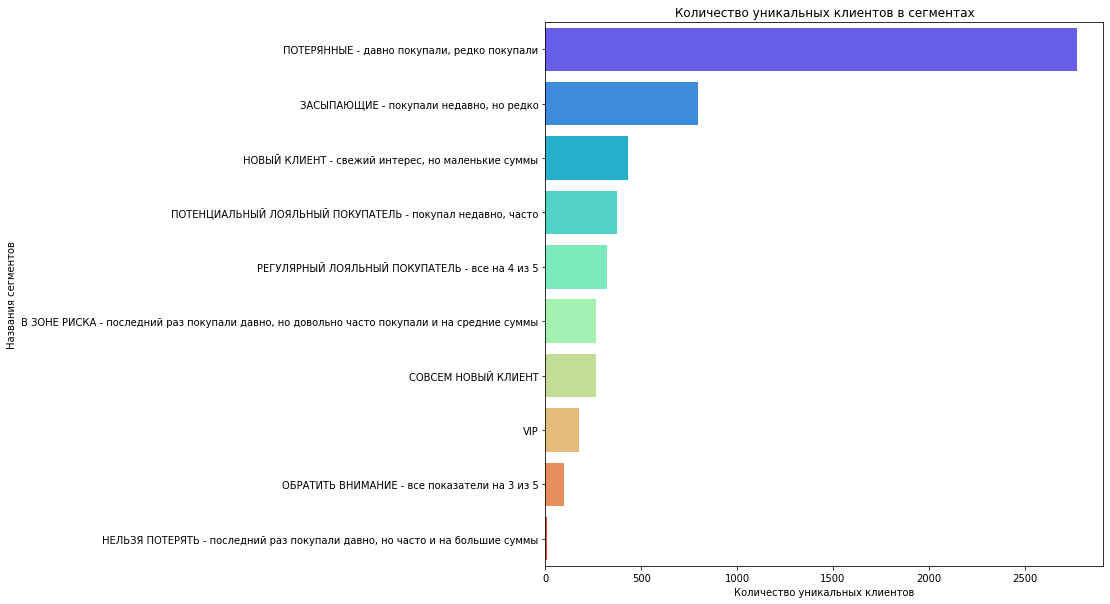

In [80]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x='connect', y='segment', data=segment_names, palette='rainbow')
plt.xlabel('Количество уникальных клиентов')
plt.ylabel('Названия сегментов')
plt.title('Количество уникальных клиентов в сегментах')
labels = ax.get_xticklabels()

## Пост-обработка

In [82]:
del df['days_since_prev_order']

In [83]:
df.columns = (['№_заказа', 'Дата', 'Менеджер', 'Состав_заказа', 'Имя_клиента', 'Номер_тел', 
               'Способ_доставки', 'Пункт_доставки', 'Сумма_заказа', 'Стоимость_доставки', 'Конечная_сумма', 
               'Длина_номера_тел', 'Recency', 'Frequency', 'Monetary', 'R', 'F',
               'M', 'RFM_баллы', 'Название_сегмента', 'Средний_чек', 'Медианный_чек'])

In [105]:
dv = pd.read_excel('result.xlsx')

In [106]:
dv = dv.drop(columns=['Unnamed: 0', 'tel_len'])

In [108]:
dv = dv.rename(columns={"tel": "Номер_тел"})

In [172]:
dv.email = dv.email.fillna(0)

In [176]:
dv['email'].value_counts()

0                             1832
project@mrnr.ru                 36
horhorio1@mail.ru               22
smirnovaairina67@gmail.com      18
vip.elenapiter@mail.ru          14
                              ... 
chuduknadezda@rambler.ru         1
elena-1970-18@mail.ru            1
uavinov@gmail.com                1
Yulya1990-14@mail.ru             1
natasha_20mol@mail.ru            1
Name: email, Length: 2195, dtype: int64

In [158]:
df['g']=df.groupby('Номер_тел').cumcount()
dv['g']=dv.groupby('Номер_тел').cumcount()
df = df.merge(dv,how='outer').drop('g',1)

In [159]:
df = df.dropna(subset=['Дата'])

In [160]:
df = df[['№_заказа', 'Дата', 'Менеджер', 'Состав_заказа', 'Имя_клиента', 'Номер_тел','email', 
               'Способ_доставки', 'Пункт_доставки', 'Сумма_заказа', 'Стоимость_доставки', 'Конечная_сумма', 
               'Длина_номера_тел', 'Recency', 'Frequency', 'Monetary', 'R', 'F',
               'M', 'RFM_баллы', 'Название_сегмента', 'Средний_чек', 'Медианный_чек']]

In [164]:
df.email = df.email.fillna(0)

In [168]:
df.email.nunique()

1989

In [211]:
sliced = df.query('email != 0').pivot_table(index=['RFM_баллы','Название_сегмента','Номер_тел','email','Имя_клиента'],
                                            values=['Медианный_чек', 'Средний_чек']).sort_values('RFM_баллы', ascending=False)

## Экспорт

In [167]:
davita_rfm = pd.ExcelWriter('davita_rfm.xlsx', engine='xlsxwriter')
df.to_excel(davita_rfm, sheet_name='Все данные')
df.query('email != 0').to_excel(davita_rfm, sheet_name='Есть Email')
df.query('Название_сегмента == "ПОТЕРЯННЫЕ - давно покупали, редко покупали"').to_excel(davita_rfm, sheet_name='ПОТЕРЯННЫЕ')
df.query('Название_сегмента == "В ЗОНЕ РИСКА - последний раз покупали давно, но довольно часто покупали и на средние суммы"').to_excel(davita_rfm, sheet_name='В_ЗОНЕ_РИСКА')
df.query('Название_сегмента == "ЗАСЫПАЮЩИЕ - покупали недавно, но редко"').to_excel(davita_rfm, sheet_name='ЗАСЫПАЮЩИЕ')
df.query('Название_сегмента == "НЕЛЬЗЯ ПОТЕРЯТЬ - последний раз покупали давно, но часто и на большие суммы"').to_excel(davita_rfm, sheet_name='НЕЛЬЗЯ_ПОТЕРЯТЬ')
df.query('Название_сегмента == "ОБРАТИТЬ ВНИМАНИЕ - все показатели на 3 из 5"').to_excel(davita_rfm, sheet_name='ОБРАТИТЬ_ВНИМАНИЕ')
df.query('Название_сегмента == "НОВЫЙ КЛИЕНТ - свежий интерес, но маленькие суммы"').to_excel(davita_rfm, sheet_name='НОВЫЙ_КЛИЕНТ')
df.query('Название_сегмента == "СОВСЕМ НОВЫЙ КЛИЕНТ"').to_excel(davita_rfm, sheet_name='СОВСЕМ_НОВЫЙ_КЛИЕНТ')
df.query('Название_сегмента == "ПОТЕНЦИАЛЬНЫЙ ЛОЯЛЬНЫЙ ПОКУПАТЕЛЬ - покупал недавно, часто"').to_excel(davita_rfm, sheet_name='ПОТЕНЦ_ЛОЯЛ_ПОКУПАТЕЛЬ')
df.query('Название_сегмента == "РЕГУЛЯРНЫЙ ЛОЯЛЬНЫЙ ПОКУПАТЕЛЬ - все на 4 из 5"').to_excel(davita_rfm, sheet_name='РЕГ_ЛОЯЛ_ПОКУПАТЕЛЬ')
df.query('Название_сегмента == "VIP"').to_excel(davita_rfm, sheet_name='VIP')
davita_rfm.save()

In [212]:
writer = pd.ExcelWriter('davita_rfm_email.xlsx', engine='xlsxwriter')
sliced.to_excel(writer)
writer.save()

# Общий вывод:
1) Предобработка:

 - После обработки пропусков удалено <span style='color: red;'>1933 строки.<br>
<br>
    
 - Телефонные номера отформатированы к единому виду. Определены причины появления номеров различной длины. Номера с кодом страны 7 заменены на 8. Все российские номера начинаются с 8. Все данные приведены к нужным форматам. <span style='color: red;'>Удалено еще 65 записей.<br>
<br>
<b>В результате предобработки датасет сократился с 12660 записей до 10662. <span style='color: red;'>Удалено 1998 записей - 16% от исходных данных.</span></b>

2) Формирование RFM-модели:
- Вся база охватывает 1121 день.
<br>
<br>
- Расчитан параметр recency. В качестве точки отсчета взят следующий день от последней даты в исходной таблице - 22 февраля 2020 года. Создан новый столбец с данными о количестве прошедших дней с последней покупки. Создан столбец Recency с минимальной давностью от 22 февраля 2020 года для каждого пользователя.
<br>
<br>
- Frequency - расчитано общее количество покупок для каждого пользователя за весь период.
<br>
<br>
- Monetary - расчитана потраченная сумма для каждого пользователя за весь период.
<br>
<br>
- К каждому параметру применен метод статистики quantile(), который сортирует всю выборку по возрастанию и делит на одинаковые отрезки (квантили) по 20%.<br>
В <b>recency</b> верхняя граница первого квантиля доходит до 60 дней, т.е 20% пользовалелей покупали в период последних двух месяцев. Они получили высший бал R5. R1 для пользователей, которые покупали более 567 дней назад.<br>
В <b>frequency</b> только 20% пользователей делали больше 7 покупок, а 60% делали меньше 3х за все время. R5 для тех, кто покупал от 7 раз. R1 - для купивших 1 раз.<br>
В <b>monetary</b> 20% клиентов купили на сумму больше 31273 за все время. R5 для тех, кто потратил от 31273 рублей. R1 - для купивших на сумму меньше 3080 рублей.
<br>
<br>
- Получено 95 комбинаций. Баллы для каждого пользователя хранятся в отдельном столбце
<br>
<br>
- Для полученых комбинаций придумано 10 сегментов:<br>
 1) 'ПОТЕРЯННЫЕ - давно покупали, редко покупали'<br>
 2) 'В ЗОНЕ РИСКА - последний раз покупали давно, но довольно часто покупали и на средние суммы'<br>
 3) 'НЕЛЬЗЯ ПОТЕРЯТЬ - последний раз покупали давно, но часто и на большие суммы'<br>
 4) 'ЗАСЫПАЮЩИЕ - покупали недавно, но редко'<br>
 5) 'ОБРАТИТЬ ВНИМАНИЕ - все показатели на 3 из 5'<br>
 6) 'РЕГУЛЯРНЫЙ ЛОЯЛЬНЫЙ ПОКУПАТЕЛЬ - все на 4 из 5'<br>
 7) 'НОВЫЙ КЛИЕНТ - свежий интерес, но маленькие суммы'<br>
 8) 'СОВСЕМ НОВЫЙ КЛИЕНТ'<br>
 9) 'ПОТЕНЦИАЛЬНЫЙ ЛОЯЛЬНЫЙ ПОКУПАТЕЛЬ - покупал недавно, часто'<br>
 10) 'VIP'



3) Весь результат анализа экспортирован таблицу xlsx. Файл содержит общую таблицу и на каждом отдельном листе полученные сегменты.